In [4]:
# Importando as bibliotecas necessárias
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier
from imblearn.over_sampling import SMOTE

In [5]:
# 1. Carregar o dataset aac_intakes_outcomes.csv (substitua pelo caminho correto no Colab)
df = pd.read_csv('/content/aac_intakes_outcomes.csv', on_bad_lines='skip')
df.head()

,age_upon_outcome,animal_id_outcome,date_of_birth,outcome_subtype,outcome_type,sex_upon_outcome,age_upon_outcome_(days),age_upon_outcome_(years),age_upon_outcome_age_group,outcome_datetime,...,age_upon_intake_age_group,intake_datetime,intake_month,intake_year,intake_monthyear,intake_weekday,intake_hour,intake_number,time_in_shelter,time_in_shelter_days
0,10 years,A006100,2007-07-09 00:00:00,NaN,Return to Owner,Neutered Male,3650,10.0,"(7.5, 10.0]",2017-12-07 14:07:00,...,"(7.5, 10.0]",2017-12-07 00:00:00,12,2017,2017-12,Thursday,14,1.0,0 days 14:07:00.000000000,0.588194
1,7 years,A006100,2007-07-09 00:00:00,NaN,Return to Owner,Neutered Male,2555,7.0,"(5.0, 7.5]",2014-12-20 16:35:00,...,"(5.0, 7.5]",2014-12-19 10:21:00,12,2014,2014-12,Friday,10,2.0,1 days 06:14:00.000000000,1.259722
2,6 years,A006100,2007-07-09 00:00:00,NaN,Return to Owner,Neutered Male,2190,6.0,"(5.0, 7.5]",2014-03-08 17:10:00,...,"(5.0, 7.5]",2014-03-07 14:26:00,3,2014,2014-03,Friday,14,3.0,1 days 02:44:00.000000000,1.113889
3,10 years,A047759,2004-04-02 00:00:00,Partner,Transfer,Neutered Male,3650,10.0,"(7.5, 10.0]",2014-04-07 15:12:00,...,"(7.5, 10.0]",2014-04-02 15:55:00,4,2014,2014-04,Wednesday,15,1.0,4 days 23:17:00.000000000,4.970139
4,16 years,A134067,1997-10-16 00:00:00,NaN,Return to Owner,Neutered Male,5840,16.0,"(15.0, 17.5]",2013-11-16 11:54:00,...,"(15.0, 17.5]",2013-11-16 09:02:00,11,2013,2013-11,Saturday,9,1.0,0 days 02:52:00.000000000,0.119444


In [6]:
# 2. Limpeza e preparação dos dados
# Remover colunas irrelevantes
df = df.drop(columns=['animal_id_outcome', 'outcome_subtype', 'outcome_datetime', 'found_location',
                      'outcome_monthyear', 'date_of_birth', 'dob_monthyear', 'intake_datetime', 'intake_monthyear'])


In [7]:
# Criando a variável alvo: 'adopted'
df['adopted'] = df['outcome_type'].apply(lambda x: 1 if x == 'Adoption' else 0)

# 3. Selecionar colunas de interesse e remover valores nulos
# Adicionamos a coluna time_in_shelter_days junto com outras variáveis.
selected_columns = ['age_upon_intake_(years)', 'intake_condition', 'animal_type', 'breed',
                    'color', 'sex_upon_intake', 'time_in_shelter_days', 'adopted']

df = df[selected_columns]
df = df.dropna()

In [8]:
# 4. Convertendo variáveis categóricas em variáveis numéricas (One-Hot Encoding)
df = pd.get_dummies(df, columns=['intake_condition', 'animal_type', 'breed', 'color', 'sex_upon_intake'], drop_first=True)
df.head()


,age_upon_intake_(years),time_in_shelter_days,adopted,intake_condition_Feral,intake_condition_Injured,intake_condition_Normal,intake_condition_Nursing,intake_condition_Other,intake_condition_Pregnant,intake_condition_Sick,...,color_Yellow/Gray,color_Yellow/Orange,color_Yellow/Orange Tabby,color_Yellow/Tan,color_Yellow/White,color_Yellow/Yellow,sex_upon_intake_Intact Male,sex_upon_intake_Neutered Male,sex_upon_intake_Spayed Female,sex_upon_intake_Unknown
0,10.0,0.588194,0,False,False,True,False,False,False,False,...,False,False,False,False,True,False,False,True,False,False
1,7.0,1.259722,0,False,False,True,False,False,False,False,...,False,False,False,False,True,False,False,True,False,False
2,6.0,1.113889,0,False,False,True,False,False,False,False,...,False,False,False,False,True,False,False,True,False,False
3,10.0,4.970139,0,False,False,True,False,False,False,False,...,False,False,False,False,False,False,False,True,False,False
4,16.0,0.119444,0,False,True,False,False,False,False,False,...,False,False,False,False,False,False,False,True,False,False


In [10]:
# 5. Separando as variáveis preditoras (X) e a variável alvo (y)
X = df.drop(columns=['adopted'])
y = df['adopted']


In [11]:
# 6. Dividindo o conjunto de dados em treino e teste
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)


In [12]:
# 7. Lidar com o desequilíbrio de classes usando SMOTE
sm = SMOTE(random_state=42)
x_train_res, y_train_res = sm.fit_resample(x_train, y_train)

In [13]:
# Função para exibir a Matriz de Confusão e Classificação
def exibir_resultados(modelo, nome_modelo):
    y_pred = modelo.predict(x_test)

    # Avaliação do modelo
    print(f"\nRelatório de Classificação - {nome_modelo}")
    print(classification_report(y_test, y_pred, target_names=['Não adotado', 'Adotado']))

    # Exibindo a matriz de confusão
    cm = confusion_matrix(y_test, y_pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Não adotado', 'Adotado'], yticklabels=['Não adotado', 'Adotado'])
    plt.title(f'{nome_modelo} - Matriz de Confusão')
    plt.xlabel('Classe Prevista')
    plt.ylabel('Classe Verdadeira')
    plt.show()

    # Exibindo a acurácia do modelo
    print(f"Acurácia - {nome_modelo}: {accuracy_score(y_test, y_pred)}")


Relatório de Classificação - Random Forest
              precision    recall  f1-score   support

 Não adotado       0.81      0.79      0.80     13754
     Adotado       0.73      0.75      0.74     10148

    accuracy                           0.77     23902
   macro avg       0.77      0.77      0.77     23902
weighted avg       0.77      0.77      0.77     23902



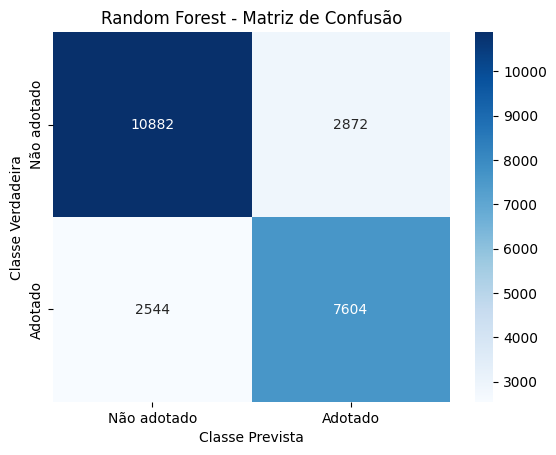

Acurácia - Random Forest: 0.7734080830056063


In [14]:
# 8. Treinamento do modelo Random Forest
model_rf = RandomForestClassifier(random_state=42)
model_rf.fit(x_train_res, y_train_res)
exibir_resultados(model_rf, "Random Forest")


In [15]:
# Exibir importância das variáveis para Random Forest
importances_rf = model_rf.feature_importances_
indices_rf = np.argsort(importances_rf)[::-1]
print("\nImportância das Variáveis no Modelo Random Forest:")
for f in range(10):
    print(f"{f + 1}. {X.columns[indices_rf[f]]} ({importances_rf[indices_rf[f]]:.4f})")



Importância das Variáveis no Modelo Random Forest:
1. time_in_shelter_days (0.4694)
2. age_upon_intake_(years) (0.1482)
3. sex_upon_intake_Unknown (0.0291)
4. intake_condition_Normal (0.0126)
5. sex_upon_intake_Intact Male (0.0119)
6. sex_upon_intake_Spayed Female (0.0099)
7. sex_upon_intake_Neutered Male (0.0091)
8. animal_type_Other (0.0066)
9. color_Black (0.0049)
10. breed_Pit Bull Mix (0.0046)


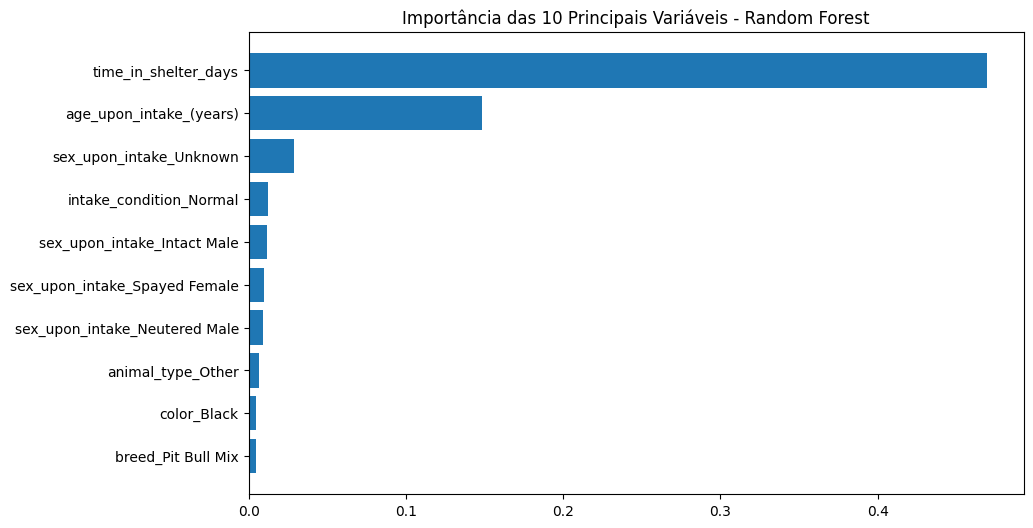

In [16]:
# Visualizando as 10 variáveis mais importantes para Random Forest
plt.figure(figsize=(10,6))
plt.title("Importância das 10 Principais Variáveis - Random Forest")
plt.barh(range(10), importances_rf[indices_rf[:10]], align="center")
plt.yticks(range(10), [X.columns[i] for i in indices_rf[:10]])
plt.gca().invert_yaxis()
plt.show()



Relatório de Classificação - Decision Tree
              precision    recall  f1-score   support

 Não adotado       0.80      0.78      0.79     13754
     Adotado       0.71      0.73      0.72     10148

    accuracy                           0.76     23902
   macro avg       0.75      0.76      0.75     23902
weighted avg       0.76      0.76      0.76     23902



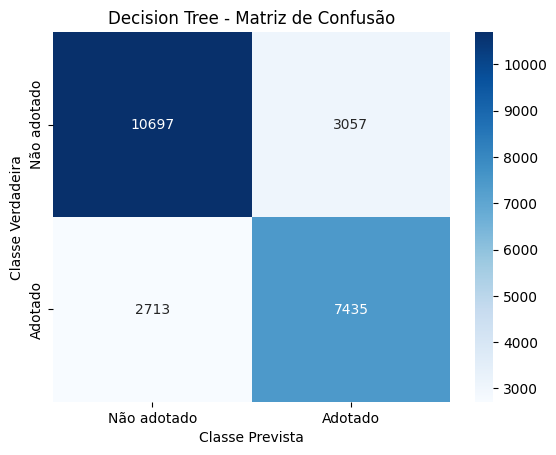

Acurácia - Decision Tree: 0.7585976068948205


In [17]:
# 9. Treinamento do modelo Decision Tree
model_dt = DecisionTreeClassifier(random_state=42)
model_dt.fit(x_train_res, y_train_res)
exibir_resultados(model_dt, "Decision Tree")

In [18]:
# Exibir importância das variáveis para Decision Tree
importances_dt = model_dt.feature_importances_
indices_dt = np.argsort(importances_dt)[::-1]
print("\nImportância das Variáveis no Modelo Decision Tree:")
for f in range(10):
    print(f"{f + 1}. {X.columns[indices_dt[f]]} ({importances_dt[indices_dt[f]]:.4f})")



Importância das Variáveis no Modelo Decision Tree:
1. time_in_shelter_days (0.5219)
2. age_upon_intake_(years) (0.1166)
3. sex_upon_intake_Intact Male (0.0123)
4. sex_upon_intake_Neutered Male (0.0110)
5. color_Black/White (0.0102)
6. sex_upon_intake_Spayed Female (0.0101)
7. animal_type_Dog (0.0100)
8. intake_condition_Normal (0.0091)
9. color_Black (0.0087)
10. breed_Pit Bull Mix (0.0072)


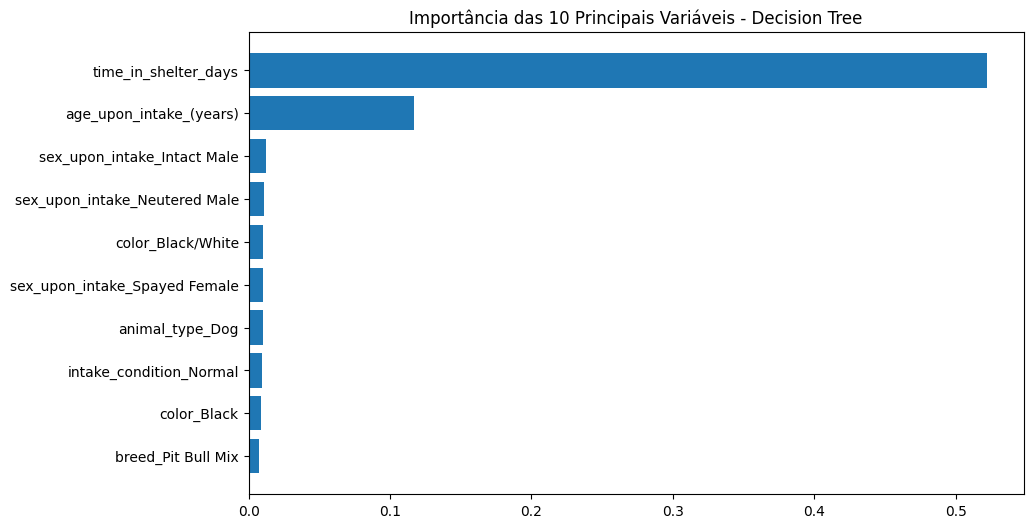

In [19]:
# Visualizando as 10 variáveis mais importantes para Decision Tree
plt.figure(figsize=(10,6))
plt.title("Importância das 10 Principais Variáveis - Decision Tree")
plt.barh(range(10), importances_dt[indices_dt[:10]], align="center")
plt.yticks(range(10), [X.columns[i] for i in indices_dt[:10]])
plt.gca().invert_yaxis()
plt.show()


Relatório de Classificação - Gradient Boosting
              precision    recall  f1-score   support

 Não adotado       0.86      0.74      0.79     13754
     Adotado       0.70      0.84      0.76     10148

    accuracy                           0.78     23902
   macro avg       0.78      0.79      0.78     23902
weighted avg       0.79      0.78      0.78     23902



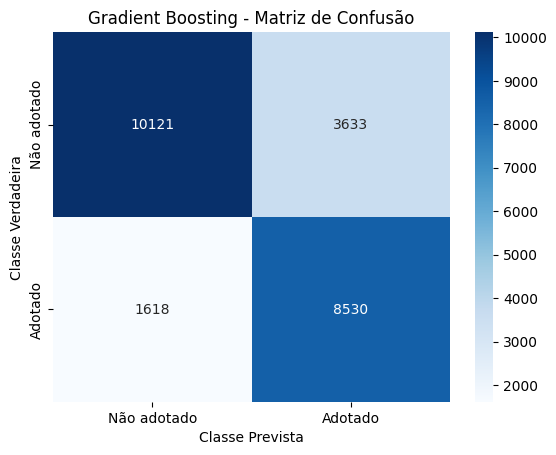

Acurácia - Gradient Boosting: 0.7803112710233453


In [20]:
# 10. Treinamento do modelo Gradient Boosting
model_gb = GradientBoostingClassifier(random_state=42)
model_gb.fit(x_train_res, y_train_res)
exibir_resultados(model_gb, "Gradient Boosting")

In [21]:
# Exibir importância das variáveis para Gradient Boosting
importances_gb = model_gb.feature_importances_
indices_gb = np.argsort(importances_gb)[::-1]
print("\nImportância das Variáveis no Modelo Gradient Boosting:")
for f in range(10):
    print(f"{f + 1}. {X.columns[indices_gb[f]]} ({importances_gb[indices_gb[f]]:.4f})")


Importância das Variáveis no Modelo Gradient Boosting:
1. time_in_shelter_days (0.7839)
2. age_upon_intake_(years) (0.1409)
3. intake_condition_Normal (0.0177)
4. sex_upon_intake_Unknown (0.0137)
5. animal_type_Dog (0.0107)
6. sex_upon_intake_Spayed Female (0.0084)
7. sex_upon_intake_Neutered Male (0.0057)
8. breed_Pit Bull Mix (0.0048)
9. breed_Chihuahua Shorthair Mix (0.0025)
10. intake_condition_Injured (0.0007)


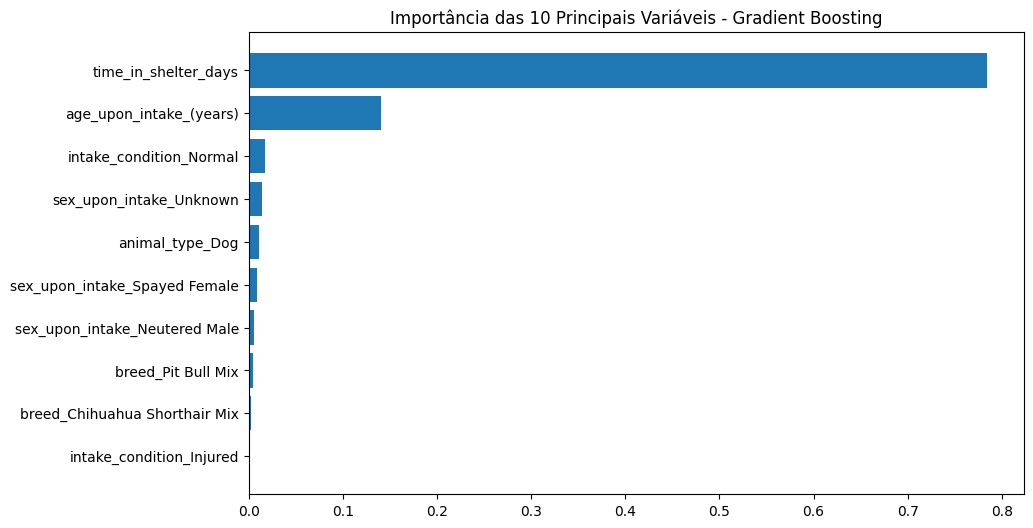

In [22]:
# Visualizando as 10 variáveis mais importantes para Gradient Boosting
plt.figure(figsize=(10,6))
plt.title("Importância das 10 Principais Variáveis - Gradient Boosting")
plt.barh(range(10), importances_gb[indices_gb[:10]], align="center")
plt.yticks(range(10), [X.columns[i] for i in indices_gb[:10]])
plt.gca().invert_yaxis()
plt.show()